*Group 30 Contributers: Zhong Tan, Nicholas Low, Stephen Huang* 

*To group 30 members: add your name here as proof of contribution*

To edit, go inside Jupyter. Click the diamond icon on the left bar. Click the cloud down arrow. Edit changes. Save. The project is now under [Changed]. Hover over it and click on the [+]. Fill in the summary with what you changed. Click [COMMIT]. Click the cloud up arrow. Everything is now updated.

**Using R and knn regression to predict used car costs in the US based on mileage, brand and year**

**Introduction**

Being able to predict used car prices can save families thousands of dollars. By using the progam language R, we can plot graphs and get a prediction for how much a car may cost. We can use a method called regression and predict a numerical value for a used car's price based on factors we enter.

We will predict the cost of a used car based on mileage and year. As background knowledge, we know that newer products with more technology cost more compared to older products with less features. We apply this knowledge to used cars in our prediction. We also know that used products are valued less than products in better conditions. Knowing that used or worn products are valued less is why we choose mileage as a factor. We believe that overall used car prices will be changed when we change mileage and year.

In our example, we use linear regression, as we want interpretability in our final results. In contrast, another option, KNN regression, tends to be more confusing to interpret. With linear regression, we might be able to predict the cost of a used car based on mileage and year. We will be using used, American car prices scraped from the web. We have taken this dataset and put it into our group's repository for easy access. To extract this dataset, we will start with read_csv() of our comma seperated sheet in .csv format, USA_cars_datasets.csv.

*Choose which RMSPE is lower in KNN vs linear regression*

**Preliminary exploratory analysis**

First we load our libraries and set our seed to make sure our work is reproducible.

In [1]:
install.packages("tidyverse")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [12]:
library(tidyverse)
library(digest)
library(repr)
library(tidymodels)
library(cowplot)
set.seed(0)
options(repr.matrix.max.rows = 8)

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Search for functions across packages at https://www.tidymodels.org/find/



Okay, let's see our data.

In [3]:
car <- read_csv("https://raw.githubusercontent.com/zhtgeneral/Group-30-Official/main/Data/USA_cars_datasets.csv")
head(car)

New names:
• `` -> `...1`
Rows: 2499 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (8): brand, model, title_status, color, vin, state, country, condition
dbl (5): ...1, price, year, mileage, lot

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1,price,brand,model,year,title_status,mileage,color,vin,lot,state,country,condition
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
0,6300,toyota,cruiser,2008,clean vehicle,274117,black,jtezu11f88k007763,159348797,new jersey,usa,10 days left
1,2899,ford,se,2011,clean vehicle,190552,silver,2fmdk3gc4bbb02217,166951262,tennessee,usa,6 days left
2,5350,dodge,mpv,2018,clean vehicle,39590,silver,3c4pdcgg5jt346413,167655728,georgia,usa,2 days left
3,25000,ford,door,2014,clean vehicle,64146,blue,1ftfw1et4efc23745,167753855,virginia,usa,22 hours left
4,27700,chevrolet,1500,2018,clean vehicle,6654,red,3gcpcrec2jg473991,167763266,florida,usa,22 hours left
5,5700,dodge,mpv,2018,clean vehicle,45561,white,2c4rdgeg9jr237989,167655771,texas,usa,2 days left


Our columns are number, price, brand, model, year, title, mileage, color, vin, lot, state, country and condition. We have 1 variable per column. We notice that we have 1 observation per row. This means we have a tidy dataset.

Since we're only looking at mileage and year, we will select those columns.

In [4]:
car <- car |>
       select(price, year, mileage)
head(car)

price,year,mileage
<dbl>,<dbl>,<dbl>
6300,2008,274117
2899,2011,190552
5350,2018,39590
25000,2014,64146
27700,2018,6654
5700,2018,45561


This is our reduced data. With only 3 columns, it will be easier to work on it. Let's get an idea for the relationship between these variables. 

Warning message:
“Removed 2 rows containing missing values (geom_point).”
Warning message:
“Removed 5 rows containing missing values (geom_point).”


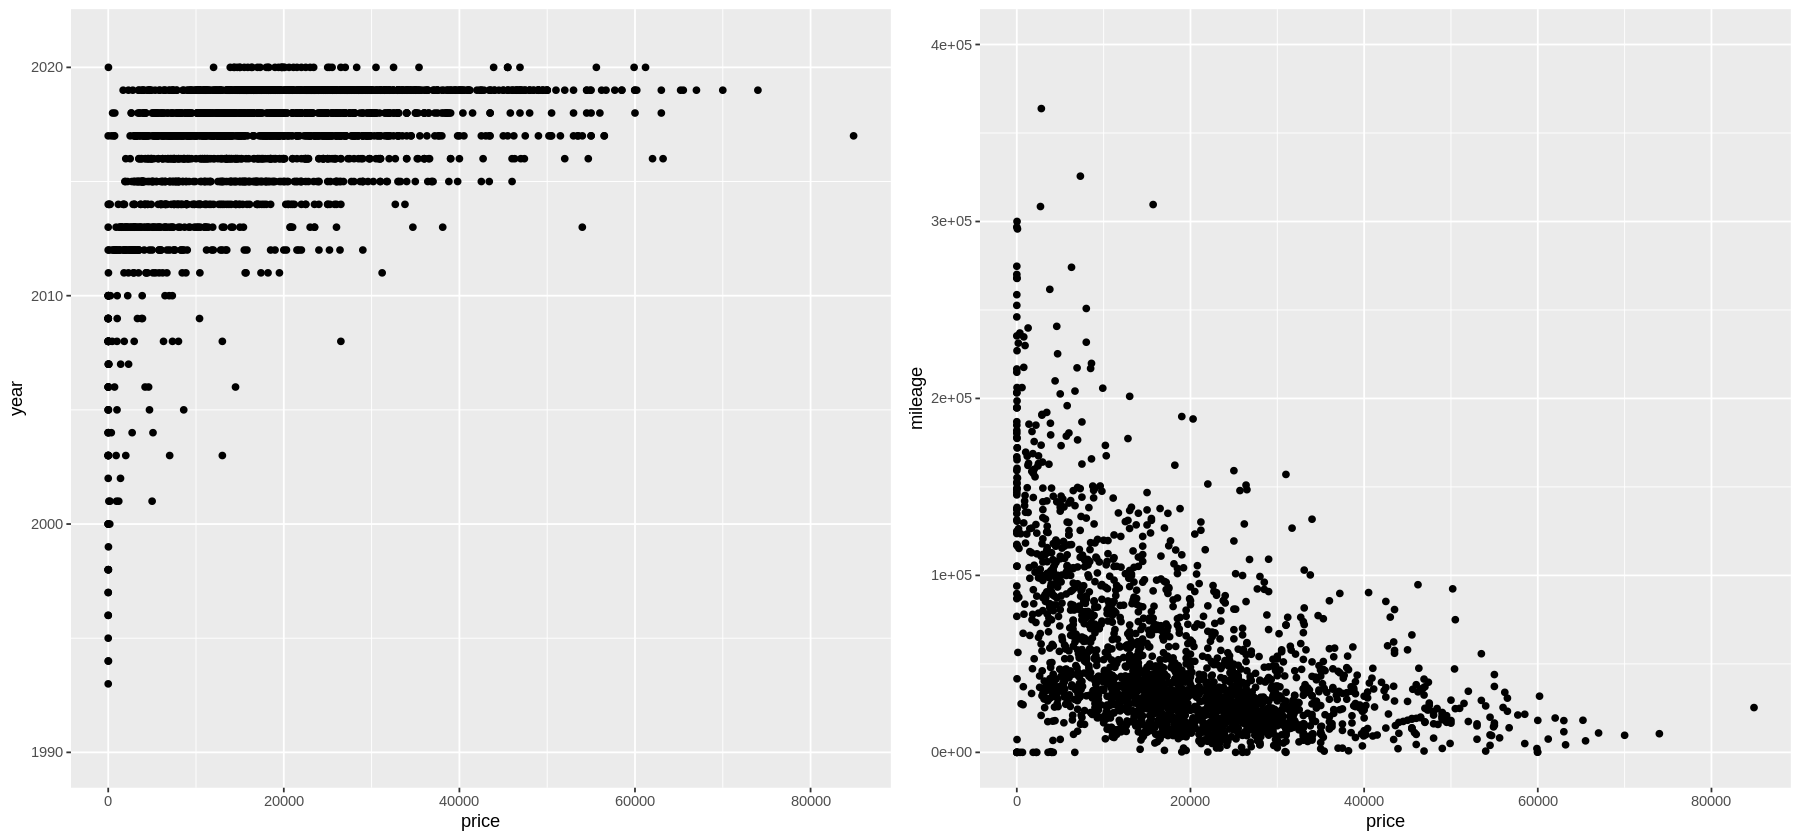

In [26]:
options(repr.plot.width = 15, repr.plot.height = 7)
car_year <- car |>
            ggplot(aes(x = price, y = year)) +
            geom_point() +
            ylim(1990, 2021)
car_mileage <- car |>
            ggplot(aes(x = price, y = mileage)) +
            geom_point() +
            ylim(0, 400000)
plot_grid(car_year, car_mileage, ncol = 2)

So these are the relationships between price and each of the variables. It seems plausible to use linear regression to represent the trends. Let's try both linear regression and KNN regression to see which RMSPE is lower and which model is more accurate.

In [35]:
# Let's use linear regression while training it with our training data.
car_split <- initial_split(car, prop = 0.75, strata =price)
car_train <- training(car_split)
car_test <- testing(car_split)

car_recipe <- recipe(price ~ mileage, year, data = car_train) |>
              step_scale(all_predictors()) |>
              step_center(all_predictors())
lin_spec <- linear_reg() |>
            set_engine("lm") |>
            set_mode("regression")
lin_fit <- workflow() |>
           add_recipe(car_recipe) |>
           add_model(lin_spec) |>
           fit(data = car_train)
lin_car_results <- lin_fit |>
                   predict(car_test) |>
                   bind_cols(car_test) |>
                   metrics(truth = price, estimate = .pred) |>
                   filter(.metric == "rmse") |>
                   pull()
lin_car_results

[1] 11439.69

This is our RMSPE when we use linear regression. Let's compare it to KNN regression.

We can notice that BWMs are not as abundant as Fords, but BMWs cost more. If we have a random, used BWM, we expect that it costs more.

**Methods**

To conduct our data analysis, we will look at only mileage, production year of the car, and the brand. The lot number, vin number, state, and the day the listing was uploaded doesn't make a difference. We can visualize our results with many scatterplots. We can use a scatterplot with price on the y axis and year/mileage on the x axis then have a bar plot with price on the x axis and brand on the y axis (like the graph above). We can also get a  measure of accuracy if we use a model called knn regression. As car brands have an effect on the price of cars (as a car from a reputable or luxury car brand will generally be marketed at a higher price than a car with the same specs from a different car brand), we will be separating the data by the car brand and performing regression on every brand individually. This way, we are able to predict car prices accounting for individual brands. We can then visualize these in a line graph and place then together using the patchwork package.

*KNN regression vs linear regression*

*Use GGPairs*

To begin, we must read and clean the data:

In [ ]:
#car_original_data <- read_csv("https://raw.githubusercontent.com/zhtgeneral/Group-30-Official/main/Data/USA_cars_datasets.csv")
#car_data_clean <- car_original_data |>
    #...
#mutate, filter, select, and skip as you see fit
#car_data_tidy

As can be seen from the tidy data set...

Now we can plot the data using the ggplot function, and add the linear regression model on top...

In [ ]:
#insert linear regression here...




#for the plots:
#car_predictions_brand1 <- car_best_fit_brand1 |>
 #   predict(car_data_training_brand1) |>
 #   bind_cols(car_data_training_brand1)
#car_predictions_brand1

#car_plot_brand1 <- car_predictions_brand1 |>
 #   ggplot(aes(x = specs, y = price)) +
 #   geom_point() +
 #   geom_line(mapping = aes(x = specs, y = .pred), color = "blue") +
 #   labs(x = "Specs", y = "Price (CAD)", color = "Predicted Time") +
 #   ggtitle("Figure 1: graph depicting the linear regression model that predicts the price of brand1 cars based off of their specs")
#car_plot_brand1

We can import the patchwork package to add the plots together:

In [ ]:
#library(patchwork)
#plot_1 + plot_2 + plot_3

**Expected Outcomes and significance**

We can expect used BMWs and Fords to cost more than the average used car. We can expect the cost of a random used car to be around between 6000 and $22000 USD based on the top 10 most abundant used cars. Being able to estimate the cost of a used car based on brand, mileage, and year can give us knowledge to know whether to wait for a better deal or to buy now. This analysis can bring insight to the question of how much can designer brand cars with high mileage be cheaper than economy brand cars with low mileage.

*Make sure to relate to intro*
